In [1]:
import pickle
from typing import Optional
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error, r2_score
from scipy.signal import savgol_filter

from scripts.config import *
from scripts.data_processing.common_methods import get_group_id, get_available_dataset_ids, get_processed_data
from scripts.data_processing.common_methods import get_df_test_tracker, load_preprocessed_data, get_preprocessed_data_files
from scripts.data_processing.postprocessing import get_health_features_from_rpt_data, extract_cccv_charge


In [2]:
def get_dQdV_cell(dataset_id:str, cell_id:Optional[int]=None) -> pd.DataFrame:
	"""Maps the dQdV data to voltage, SOC, and SOH for every cell

	Args:
		dataset_id (str): _description_
		cell_id (Optional[int]): Returns the data for the specified cell, or all cells if None

	Returns:
		pd.DataFrame: dQdV data
	"""
	
	filename = f"dQdV_{dataset_id}.pkl"
	dir_save = dir_results.joinpath("dQdV")
	dir_save.mkdir(exist_ok=True, parents=True)
	
	if not dir_save.joinpath(filename).exists():
		#region: if first time being run, generate all data
		df_test_tracker = get_df_test_tracker(dataset_id)
		df_test_tracker.dropna(axis=0, subset=['Cell ID', 'Group ID'], inplace=True)

		vbounds = None
		if dic_available_dataset_info[dataset_id]['cell_chemistry'] == 'LFP':
			vbounds = (2,3.6)
		elif dic_available_dataset_info[dataset_id]['cell_chemistry'] == 'NMC':
			vbounds = (2.5,4.2)
		df_new = pd.DataFrame(columns=['Cell ID', 'Group ID', 'RPT Number', 'SOH (%)', 'dQdV', 'Voltage (V)', 'Capacity (Ah)', 'SOC (%)'])

		for c_id in df_test_tracker['Cell ID'].astype(int).unique():
			group_id = get_group_id(dataset_id=dataset_id, cell_id=c_id)
			rpt_data = load_preprocessed_data(get_preprocessed_data_files(dataset_id=dataset_id, data_type='rpt', cell_id=c_id))

			df_health_features = get_health_features_from_rpt_data(dataset_id=dataset_id, rpt_data=rpt_data)

			temp = {'Cell ID':[], 'Group ID':[], 'RPT Number':[], 'SOH (%)':[], 'dQdV':[], 'Voltage (V)':[], 'Capacity (Ah)':[], 'SOC (%)':[],}

			df_cc = extract_cccv_charge(dataset_id=dataset_id, rpt_data=rpt_data, plot_interpolation=False)
			q_nom = df_health_features.loc[df_health_features['rpt'] == 0, 'q_dchg'].values[0]
			for rpt_num,df_split in df_cc.sort_values(by=['RPT Number', 'Time (s)'], ascending=[True, True]).groupby('RPT Number'):
				q_dchg = df_health_features.loc[df_health_features['rpt'] == rpt_num, 'q_dchg'].values[0]
				# get dQ/dV & SOH
				v, q = (None, None)
				if dataset_id == 'UConn-ILCC-LFP': 		# has CC-CV so need to filter to only CC portion
					v = df_split.loc[df_split['Current (A)'] > 1.19, 'Voltage (V)'].values
					q = df_split.loc[df_split['Current (A)'] > 1.19, 'Capacity (Ah)'].values
				elif dataset_id == 'UConn-ILCC-NMC': 	# is only a CC so can use all values
					v = df_split['Voltage (V)'].values
					q = df_split['Capacity (Ah)'].values
				vs_interp = np.linspace(vbounds[0], vbounds[1], 1000)

				from scipy.interpolate import make_interp_spline
				v_unique, idx_unique = np.unique(v, return_index=True)
				q_unique = q[idx_unique]
				spline = make_interp_spline(v_unique, q_unique, k=3)
				qs_interp = spline(vs_interp)

				dqdv_interp = np.diff(qs_interp) / np.diff(vs_interp)

				temp['Cell ID'].append(np.full(len(dqdv_interp), c_id))
				temp['Group ID'].append(np.full(len(dqdv_interp), group_id))
				temp['RPT Number'].append(np.full(len(dqdv_interp), rpt_num))
				temp['dQdV'].append(dqdv_interp)
				temp['Voltage (V)'].append(vs_interp[1:])
				temp['Capacity (Ah)'].append(qs_interp[1:])
				temp['SOH (%)'].append(np.full(len(dqdv_interp), q_dchg/q_nom*100))
				temp['SOC (%)'].append(np.full(len(dqdv_interp), qs_interp[1:]/np.max(qs_interp)*100))

			temp['Cell ID'] = np.asarray(temp['Cell ID']).ravel()
			temp['Group ID'] = np.asarray(temp['Group ID']).ravel()
			temp['RPT Number'] = np.asarray(temp['RPT Number']).ravel()
			temp['dQdV'] = np.asarray(temp['dQdV']).ravel()
			temp['Voltage (V)'] = np.asarray(temp['Voltage (V)']).ravel()
			temp['Capacity (Ah)'] = np.asarray(temp['Capacity (Ah)']).ravel()
			temp['SOH (%)'] = np.asarray(temp['SOH (%)']).ravel()
			temp['SOC (%)'] = np.asarray(temp['SOC (%)']).ravel()

			if df_new.empty:
				df_new = pd.DataFrame(temp)
			else:
				df_new = pd.concat([df_new, pd.DataFrame(temp)], ignore_index=True)
		#endregion

		# save data
		pickle.dump(df_new, open(dir_save.joinpath(filename), 'wb'))

	# load saved data and return data for this cell
	df = pickle.load(open(dir_save.joinpath(filename), 'rb'))
	if cell_id is not None:
		return df.loc[df['Cell ID'] == cell_id]
	else:
		return df

get_dQdV_cell(dataset_id='UConn-ILCC-NMC')

,Cell ID,Group ID,RPT Number,SOH (%),dQdV,Voltage (V),Capacity (Ah),SOC (%)
0,17,5,0,100.000000,0.000000,2.5017,0.000000,0.000000
1,17,5,0,100.000000,0.000000,2.5034,0.000000,0.000000
2,17,5,0,100.000000,0.000000,2.5051,0.000000,0.000000
3,17,5,0,100.000000,0.000000,2.5068,0.000000,0.000000
4,17,5,0,100.000000,0.000000,2.5085,0.000000,0.000000
...,...,...,...,...,...,...,...,...
1300995,44,11,28,52.236524,1.143826,4.1932,0.959325,99.021539
1300996,44,11,28,52.236524,1.552331,4.1949,0.961964,99.293932
1300997,44,11,28,52.236524,1.388898,4.1966,0.964325,99.537648
1300998,44,11,28,52.236524,1.552383,4.1983,0.966964,99.810051


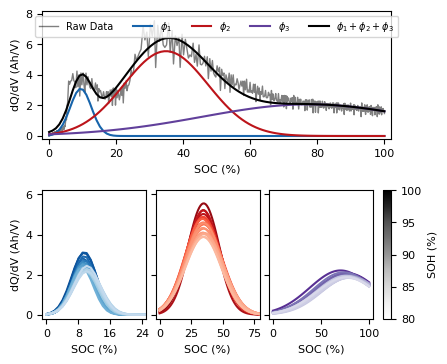

In [3]:
from scipy.optimize import curve_fit
from scipy.stats import truncnorm
import warnings
from scipy.optimize import OptimizeWarning
warnings.simplefilter("error", OptimizeWarning)


def fit_multi_gaussian(dataset_id:str, cell_id:int, rpt_num:int, n_bins:int=100, return_raw:bool=False, x_unit:str='capacity'):
	assert x_unit in ['capacity', 'soc']
	
	df = get_dQdV_cell(dataset_id=dataset_id, cell_id=cell_id)
	df = df.loc[df['SOH (%)'] >= 80.0]

	#region: extract dqdv v q data
	df_filt = df.loc[df['RPT Number'] == rpt_num]
	xs = None
	if x_unit == 'capacity':
		xs = df_filt['Capacity (Ah)'].values
	elif x_unit == 'soc':
		xs = df_filt['SOC (%)'].values
	else: raise ValueError

	
	dqdvs =  df_filt['dQdV'].values # savgol_filter(df_filt['dQdV'].values, window_length=2, polyorder=1) # 
	xs_interp = np.linspace(np.min(xs), np.max(xs), n_bins)
	dqdvs_interp = np.interp(xs_interp, xs, dqdvs)
	q_nom = np.max(xs_interp)

	peak_guess = None
	if dataset_id == 'UConn-ILCC-NMC':
		if x_unit == 'capacity':
			peak_guess = {
				'amplitudes':[3, 6, 1],
				'means':[0.1*q_nom, 0.3*q_nom, 0.5*q_nom],
				'stds':[0.01*q_nom, 0.04*q_nom, 0.04*q_nom],
				'offset':1
			}
		elif x_unit == 'soc':
			peak_guess = {
				'amplitudes':[3, 6, 1],
				'means':[0.1*100, 0.3*100, 0.5*100],
				'stds':[0.01*100, 0.04*100, 0.04*100],
				'offset':1
			}
	else:
		raise ValueError("LFP dataset not optimized yet")

	def gaussian(x, A, mu, sig):
		return A * np.exp(-(x-mu)**2 / (2*sig**2))

	def multi_gaussian(x, *pars):
		offset = pars[-1]
		g1 = gaussian(x, pars[0], pars[1], pars[2])
		g2 = gaussian(x, pars[3], pars[4], pars[5])
		g3 = gaussian(x, pars[6], pars[7], pars[8])
		return g1 + g2 + g3 + offset

	def multi_gaussian_trunc(x, *params):
		'''
		Defines a model consisting of multiple truncated gaussians
		Each truncnorm requires an: amplitude, mean, std
		'''
		y = np.zeros_like(x)
		for i in range(0, len(params), 3):
			amp, mean, std = params[i:i+3]
			y += amp * truncnorm.pdf(x, 
									-np.inf, #(np.min(x) - mean) / std, 
									(np.max(x) - mean) / std, 
									loc=mean, scale=std)
		return y
	#endregion

	#region: fit multiple gaussians
	guess = [
		[peak_guess['amplitudes'][i], peak_guess['means'][i], peak_guess['stds'][i]] for i in range(len(peak_guess['means']))
	]
	guess = np.asarray([guess]).ravel()
	sigma = np.ones(len(xs_interp))
	sigma[0] = 0.2  	    # High weight for first half
	sigma[-30:-1] = 0.2 	# High weight for last point
	popt, pcov = curve_fit(multi_gaussian_trunc, xs_interp, dqdvs_interp, guess, sigma=sigma)
	#endregion

	ys = [multi_gaussian_trunc(xs_interp, *popt)]
	for i in range(0, len(popt), 3):
		amp, mean, std = popt[i:i+3]
		ys.append(amp * truncnorm.pdf(xs_interp, -np.inf, (np.max(xs_interp) - mean) / std, loc=mean, scale=std))

	if return_raw:
		raw_dic = {'xs':xs, 'dqdvs':dqdvs}
		return xs_interp, ys, raw_dic
	return xs_interp, ys

def plot_multi_gaussian_fit(dataset_id:str, cell_id:int, x_unit:str='capacity'):
	assert x_unit in ['capacity', 'soc']

	cms = [mpl.cm.Blues, mpl.cm.Reds, mpl.cm.Purples]
	fig = plt.figure(figsize=(4.5,4))
	gs = GridSpec(figure=fig, ncols=4, nrows=2, hspace=0.4, wspace=0.12, width_ratios=[12,12,12,1])
	axes = [
		fig.add_subplot(gs[0, :]),
		fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1]), fig.add_subplot(gs[1, 2]), fig.add_subplot(gs[1, 3])
	]
	for i in range(2,4,1):
		# axes[i].sharex(axes[1])
		axes[i].sharey(axes[1])
		plt.setp(axes[i].get_yticklabels(), visible=False)

	#region: plot fresh cell dQdV
	x, ys, raw_dic = fit_multi_gaussian(
		dataset_id=dataset_id,
		cell_id=cell_id,
		rpt_num=1,
		return_raw=True,
		x_unit=x_unit
	)
	axes[0].plot(raw_dic['xs'], raw_dic['dqdvs'], 'k-', alpha=0.5, linewidth=1, label='Raw Data')
	for i, y in enumerate(ys[1:]):
		axes[0].plot(x, y, '-', color=cms[i](0.8), label=fr"$\phi_{i+1}$")
	axes[0].plot(x, ys[0], 'k-', label=r"$\phi_1+\phi_2+\phi_3$")
	axes[0].legend(fontsize=7, loc='upper center', ncols=5)

	axes[0].set_xlabel("Capacity [Ah]" if x_unit == 'capacity' else "SOC (%)", fontsize=8)
	axes[0].set_xticks(np.arange(0,101,20), np.arange(0,101,20).astype(int), fontsize=8)
	axes[0].set_xlim(-2,102)
	axes[0].set_ylabel(r"dQ/dV (Ah/V)", fontsize=8)
	axes[0].set_yticks(np.arange(0,8.1,2), np.arange(0,8.1,2).astype(int), fontsize=8)
	axes[0].set_ylim(-0.2,8.2)
	
	#endregion

	#region: plot each phase gaussian over the entire SOH range
	axes[1].set_ylabel(r"dQ/dV (Ah/V)", fontsize=8)
	axes[1].set_yticks(np.arange(0,6.1,2), np.arange(0,6.1,2).astype(int), fontsize=8)
	axes[1].set_ylim(-0.2,6.2)

	cell_data = get_processed_data(dataset_id=dataset_id, data_type='slowpulse')
	filt_idxs = np.where((cell_data['soh'] >= 80.0) & (cell_data['cell_id'] == cell_id))
	max_rpt = np.max(cell_data['rpt'][filt_idxs])
	for rpt_num in range(1,max_rpt):
		rpt_idxs = np.where((cell_data['cell_id'] == cell_id) & (cell_data['rpt'] == rpt_num))[0][0]
		soh = cell_data['soh'][rpt_idxs]

		with warnings.catch_warnings():
			warnings.simplefilter("error", OptimizeWarning)
			try:
				x, ys = fit_multi_gaussian(dataset_id=dataset_id, cell_id=cell_id, rpt_num=rpt_num, x_unit=x_unit)
			except OptimizeWarning:
				print(f"RPT {rpt_num} dropped. Failed to optimize")
				continue
		for i in range(1,4):
			scm = mpl.cm.ScalarMappable(cmap=cms[i-1], norm=mpl.colors.Normalize(vmin=75, vmax=100))
			axes[i].plot(x, ys[i], color=scm.to_rgba(soh))

	for i in range(1,4):
		# axes[i].set_title(r"$\phi$" + f"{i} Gaussian", fontsize=8)
		axes[i].set_xlabel("Capacity [Ah]" if x_unit == 'capacity' else "SOC (%)", fontsize=8)
	axes[1].set_xticks(np.arange(0,25,8), np.arange(0,25,8).astype(int), fontsize=8)
	axes[1].set_xlim(-1,25)
	axes[2].set_xticks(np.arange(0,76,25), np.arange(0,76,25).astype(int), fontsize=8)
	axes[2].set_xlim(-3,79)
	axes[3].set_xticks(np.arange(0,101,50), np.arange(0,101,50).astype(int), fontsize=8)
	axes[3].set_xlim(-4,104)

	scm = mpl.cm.ScalarMappable(cmap=mpl.cm.Greys, norm=mpl.colors.Normalize(vmin=80, vmax=100))
	cbar = fig.colorbar(scm, cax=axes[4])
	cbar.ax.tick_params(labelsize=8)
	cbar.set_label(label='SOH (%)', size=8)
	#endregion

	return fig, axes, cbar

dataset_id='UConn-ILCC-NMC'
pulse_type='chg'
file_type = 'png'
save = False

fig, axes, cbar = plot_multi_gaussian_fit(
	dataset_id=dataset_id,
	cell_id=1, 
	x_unit='soc')
dir_save = dir_figures.joinpath("dQdV Analysis", "Distribution Difference")
dir_save.mkdir(exist_ok=True, parents=True)
filename = f"PhaseIsolation {dataset_id} {pulse_type} (cell01).{file_type}"
if save: fig.savefig(dir_save.joinpath(filename), dpi=300, bbox_inches='tight')
plt.show()

### Record the dQ/dV Value belonging to each phase transition

In [4]:
def get_phase_transition_baseline(dataset_id:str, cell_id:int=44):
	assert dataset_id in ['UConn-ILCC-NMC']
	res = {
		'cell_id':[],
		'rpt':[],
		'soh':[],
		'socs':[],
		'theta_all':[],
		'theta_1':[],
		'theta_2':[],
		'theta_3':[],
	}

	cell_data = get_processed_data(dataset_id=dataset_id, data_type='slowpulse')
	
	filt_idxs = np.where((cell_data['soh'] >= 75.0) & (cell_data['cell_id'] == cell_id))
	max_rpt = np.max(cell_data['rpt'][filt_idxs])
	for rpt_num in range(0,max_rpt):
		rpt_idxs = np.where((cell_data['cell_id'] == cell_id) & (cell_data['rpt'] == rpt_num))[0][0]
		soh = cell_data['soh'][rpt_idxs]

		with warnings.catch_warnings():
			warnings.simplefilter("error", OptimizeWarning)
			try:
				x, ys = fit_multi_gaussian(dataset_id=dataset_id, cell_id=cell_id, rpt_num=rpt_num, n_bins=1000, x_unit='soc')
			except:
				print(f"RPT {rpt_num} dropped. Failed to optimize")
				continue

			res['socs'].append(x)
			res['theta_all'].append(ys[0])
			res['theta_1'].append(ys[1])
			res['theta_2'].append(ys[2])
			res['theta_3'].append(ys[3])
			res['cell_id'].append(np.full_like(x, cell_id))
			res['soh'].append(np.full_like(x, soh))
			res['rpt'].append(np.full_like(x, rpt_num))
	for k in res.keys():
		res[k] = np.asarray(res[k]).flatten()
	df = pd.DataFrame(res)

	return df

def get_phase_transition_data(dataset_id:str, pulse_type:str):
	assert dataset_id in ['UConn-ILCC-LFP', 'UConn-ILCC-NMC']
	assert pulse_type in ['chg']

	dir_save = dir_results.joinpath("dQdV", "Using Isolated Phase Transitions")
	dir_save.mkdir(exist_ok=True, parents=True)
	filename = f"dQdV_{dataset_id}_{pulse_type}.pkl"

	def results_exist():
		return dir_save.joinpath(filename).exists()

	def load_results():
		results = pickle.load(open(dir_save.joinpath(filename), 'rb'))
		return results

	results = None
	if not results_exist():
		
		results = {'dQdV_all':[], 'dQdV_p1':[], 'dQdV_p2':[], 'dQdV_p3':[], 'pulse_soc':[], 'true_soc':[], 'rpt_num':[]}

		i_nom = 1.2 if dataset_id == 'UConn-ILCC-LFP' else 2.25
		pulse_delta_q = i_nom*(10/3600) + (i_nom/5)*(30/3600)
		pulse_data = get_processed_data(dataset_id=dataset_id, data_type='slowpulse')
		cell_ids = np.unique(pulse_data['cell_id'])
		for cell_id in cell_ids:
			# df_dQdV = get_dQdV_cell(dataset_id=dataset_id, cell_id=cell_id)
			df_phase_baseline = get_phase_transition_baseline(dataset_id, cell_id)
			cell_idxs = np.where((pulse_data['cell_id'] == cell_id) & (pulse_data['pulse_type'] == pulse_type))
			
			q_nom = pulse_data['q_dchg'][cell_idxs][np.where(pulse_data['rpt'][cell_idxs] == 0)[0][0]]
			for rpt_num in np.unique(pulse_data['rpt'][cell_idxs]):
				rpt_idxs = np.where(pulse_data['rpt'][cell_idxs] == rpt_num)
				soh = pulse_data['soh'][cell_idxs][rpt_idxs][0]
				pulse_socs = pulse_data['soc'][cell_idxs][rpt_idxs]
				for j in range(len(pulse_socs)):
					pulse_soc = pulse_socs[j]
					
					# get true SOC range for this pulse (use coulomb counting)
					pulse_true_soc_start = pulse_data['soc - coulomb'][cell_idxs][rpt_idxs][j]
					pulse_true_soc_end = pulse_true_soc_start + (pulse_delta_q/q_nom*100)
					pulse_true_soc_min = min(pulse_true_soc_start, pulse_true_soc_end)
					pulse_true_soc_max = max(pulse_true_soc_start, pulse_true_soc_end)

					# get nearest SOH value stored in baseline
					soh_idx = (np.abs(df_phase_baseline['soh'].values - soh)).argmin()
					soh_baseline = df_phase_baseline['soh'].values[soh_idx]
					# get the dQdV for each phase transition at this SOC range
					df_filt = df_phase_baseline.loc[
						(df_phase_baseline['socs'] >= pulse_true_soc_min) & \
						(df_phase_baseline['socs'] <= pulse_true_soc_max) & \
						(df_phase_baseline['soh'] == soh_baseline)]
					if df_filt.empty: 
						df_filt = df_phase_baseline.loc[
							(df_phase_baseline['soh'] == soh_baseline) & \
							(df_phase_baseline['socs'] >= pulse_true_soc_min)].iloc[0:1]

					# save values
					results['dQdV_all'].append(df_filt['theta_all'].mean())
					results['dQdV_p1'].append(df_filt['theta_1'].mean())
					results['dQdV_p2'].append(df_filt['theta_2'].mean())
					results['dQdV_p3'].append(df_filt['theta_3'].mean())
					results['pulse_soc'].append(pulse_soc)
					results['true_soc'].append(np.mean([pulse_true_soc_start, pulse_true_soc_end]))
					results['rpt_num'].append(rpt_num)

		results['dQdV_all'] = np.asarray(results['dQdV_all'])
		results['dQdV_p1'] = np.asarray(results['dQdV_p1'])
		results['dQdV_p2'] = np.asarray(results['dQdV_p2'])
		results['dQdV_p3'] = np.asarray(results['dQdV_p3'])
		results['pulse_soc'] = np.asarray(results['pulse_soc'])
		results['true_soc'] = np.asarray(results['true_soc'])
		results['rpt_num'] = np.asarray(results['rpt_num'])

		# save results
		pickle.dump(results, open(dir_save.joinpath(filename), 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
	else:
		results = load_results()

	return results
	
dQdV_data = get_phase_transition_data(
	dataset_id='UConn-ILCC-NMC', pulse_type='chg'
)

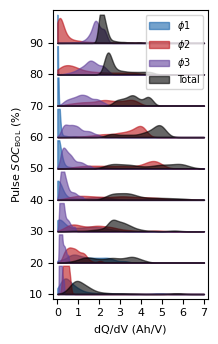

In [5]:
from scipy.stats import gaussian_kde

file_type = 'png'
save = False

phase_colors = {
	'total':'black',
	'p1':mpl.cm.Blues(0.8),
	'p2':mpl.cm.Reds(0.8),
	'p3':mpl.cm.Purples(0.8)
}

#region: plot
fig, ax = plt.subplots(figsize=(2,3.75))
dqdv_range = np.linspace(0,7,1000)
all_socs = np.unique(dQdV_data['pulse_soc'])
for i, pulse_soc in enumerate(all_socs):
	idxs = np.where(dQdV_data['pulse_soc'] == pulse_soc)
	dqdv_p1 = dQdV_data['dQdV_p1'][idxs]
	dqdv_p2 = dQdV_data['dQdV_p2'][idxs]
	dqdv_p3 = dQdV_data['dQdV_p3'][idxs]
	dqdv_all = dQdV_data['dQdV_all'][idxs]

	for j, vals in enumerate([dqdv_p1, dqdv_p2, dqdv_p3]):
		kde_vals = gaussian_kde(vals)(dqdv_range)
		kde_vals /= 2
		kde_vals[np.where(kde_vals >= 0.9)] = 0.9
		if i == 0:
			phi = r"$\phi$"
			ax.fill_between(dqdv_range, i, i+kde_vals, color=phase_colors[f'p{j+1}'], alpha=0.6, label=f'{phi}{j+1}')
		else:
			ax.fill_between(dqdv_range, i, i+kde_vals, color=phase_colors[f'p{j+1}'], alpha=0.6)
	
	#region: plot total
	kde_vals = gaussian_kde(dqdv_all)(dqdv_range)
	kde_vals /= 2
	kde_vals[np.where(kde_vals >= 0.9)] = 0.9
	# ax.plot(dqdv_range, i+kde_vals, color=phase_colors['total'], alpha=0.6,)
	if i == 0:
		ax.fill_between(dqdv_range, i, i+kde_vals, color=phase_colors['total'], alpha=0.6, label='Total')
	else:
		ax.fill_between(dqdv_range, i, i+kde_vals, color=phase_colors['total'], alpha=0.6,)
	#endregion

ax.set_yticks(np.arange(len(all_socs)), labels=all_socs, fontsize=8)
ax.set_ylabel(r"Pulse $SOC_{\mathrm{BOL}}$ (%)", fontsize=8)
ax.set_ylim(-0.15,9.05)
ax.set_xticks(np.arange(0,7.01,1), np.arange(0,7.01,1).astype(int), fontsize=8)
ax.set_xlabel("dQ/dV (Ah/V)", fontsize=8)
ax.set_xlim(-0.2,7.2)
ax.legend(fontsize=7, ncols=1, loc='upper right')
#endregion

dir_save = dir_figures.joinpath("dQdV Analysis", "Distribution Difference")
dir_save.mkdir(exist_ok=True, parents=True)
filename = f"PhaseIsolation {dataset_id} {pulse_type} PhasePDFs.{file_type}"
if save: fig.savefig(dir_save.joinpath(filename), dpi=300, bbox_inches='tight')
plt.show()

/opt/anaconda3/envs/envTL/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


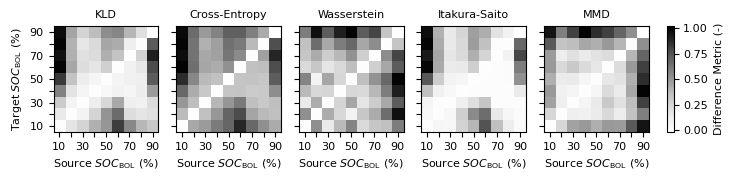

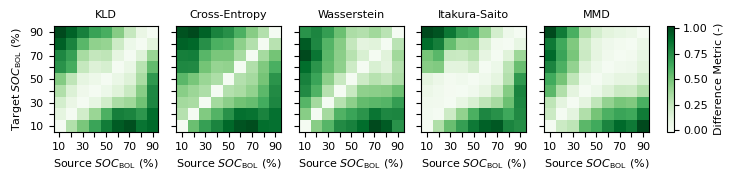

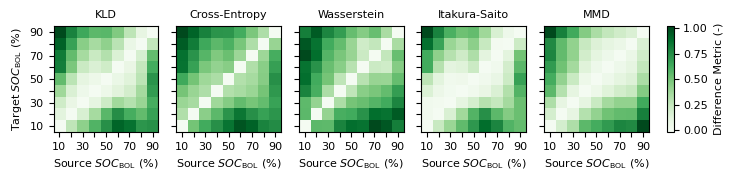

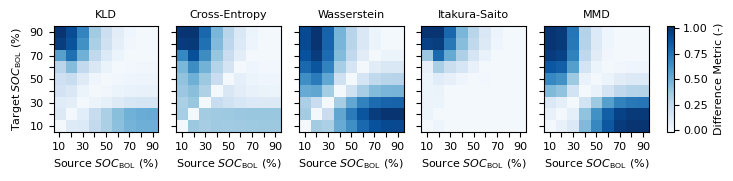

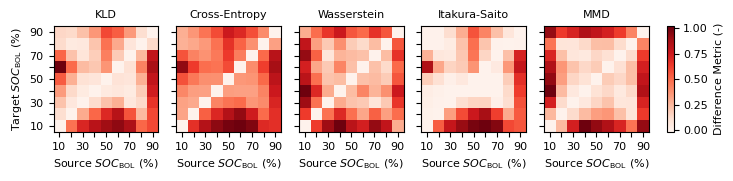

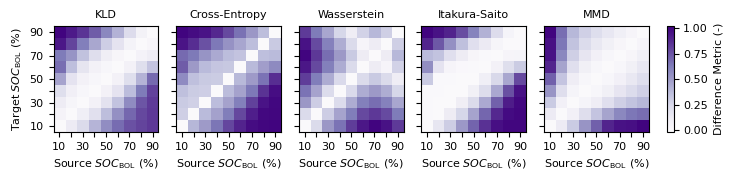

In [6]:
from scripts.modeling.fine_tuning import DistributionDifference
from scripts.modeling.fine_tuning import plot_soc_combination_grid
from scripts.modeling.fine_tuning import ErrorFunction, AbsoluteChange, PercentChange
from scripts.modeling.fine_tuning import get_finetuning_errors, fine_tuning_result_keys
from scipy.stats import pearsonr
import statsmodels.api as sm

def get_dQdV_distribution_differences(dataset_id:str, pulse_type:str, difference_metric:str, normalize:bool=True, phases:list=['p1', 'p2', 'p3', 'all']):
	res = get_phase_transition_data(
		dataset_id=dataset_id,
		pulse_type=pulse_type
	)

	#region: calculate distribution difference using dQ/dV metrics
	target_socs = source_socs = dic_available_dataset_info[dataset_id]['pulse_socs_tested']
	results = np.zeros(shape=(len(target_socs), len(source_socs)))
	for j, target_soc in enumerate(target_socs):
		for k, source_soc in enumerate(source_socs):
			if source_soc == target_soc: continue

			A = np.vstack([res[f'dQdV_{p}'][np.where(res['pulse_soc'] == source_soc)] for p in phases]).T
			B = np.vstack([res[f'dQdV_{p}'][np.where(res['pulse_soc'] == target_soc)] for p in phases]).T

			dd = DistributionDifference(A=A, B=B, nbins=100)
			results[j][k] = dd.as_dict()[difference_metric]

	# normalize difference metrics
	if normalize:
		results = (results - np.min(results)) / (np.max(results) - np.min(results))
	#endregion

	return results

def plot_dQdV_distribution_differences(dataset_id:str, pulse_type:str, phases:list, **kwargs):
	"""Plots the SOC-combination scores for all DistributionDifference metrics over the dQdV values

	Args:
		dataset_id (str): {'UConn-ILCC-LFP', 'UConn-ILCC-NMC'}
		pulse_type (str): {'chg', 'dchg'}
		phases (list): must contain a combination of the following: ['p1', 'p2', 'p3', 'all']
		**kwargs: {figsize, cmap}
	"""

	assert dataset_id in ['UConn-ILCC-LFP', 'UConn-ILCC-NMC']
	assert pulse_type in ['chg', 'dchg']

	#region: set up figure
	figsize = (8,1.375)
	if 'figsize' in kwargs: figsize = kwargs['figsize']
	cmap = mpl.cm.Blues
	if 'cmap' in kwargs: cmap = kwargs['cmap']
	soc_bol = r"$SOC_{\mathrm{BOL}}$"

	fig = plt.figure(figsize=figsize)
	gs = GridSpec(figure=fig, nrows=1, ncols=6, width_ratios=[15,15,15,15,15,1])
	axes = [fig.add_subplot(gs[0,0]), fig.add_subplot(gs[0,1]), fig.add_subplot(gs[0,2]), 
			fig.add_subplot(gs[0,3]), fig.add_subplot(gs[0,4]), fig.add_subplot(gs[0,5])]
	for i in range(1,5):
		axes[i].sharex(axes[0])
		plt.setp(axes[i].get_yticklabels(), visible=False)
	diff_metric_shorthand_names = {
		'kullback_leibler':'KLD', 'cross_entropy':'Cross-Entropy', 'wasserstein':'Wasserstein', 'itakura_saito':'Itakura-Saito', 'maximum_mean_discrepancy':'MMD',
	}
	#endregion
	
	for i, diff_metric in enumerate(['kullback_leibler', 'cross_entropy', 'wasserstein', 'itakura_saito', 'maximum_mean_discrepancy']):
		results = get_dQdV_distribution_differences(
			dataset_id=dataset_id, 
			pulse_type=pulse_type, 
			difference_metric=diff_metric,
			normalize=True,
			phases=phases)

		#region: plot metric
		all_socs = dic_available_dataset_info[dataset_id]['pulse_socs_tested']
		soc_labels = all_socs
		if dataset_id == 'UConn-ILCC-NMC':
			soc_labels = [all_socs[i] if i%2==0 else '' for i in range(len(all_socs))]
		fig, _axes, cbar = plot_soc_combination_grid(
			results=results, 
			annotations=None,
			fig=fig,
			axes=(axes[i], axes[5]),
			cmap=cmap,
			xlabel=f'Source {soc_bol} (%)',
			xticklabels=soc_labels,
			ylabel=f'Target {soc_bol} (%)' if i == 0 else '',
			yticklabels=soc_labels,
			title=diff_metric_shorthand_names[diff_metric],
			cbar_label='Difference Metric (-)')
		_axes[0].title.set_fontsize(8)
		_axes[0].xaxis.label.set_fontsize(8)
		_axes[0].xaxis.set_tick_params(labelsize=8)
		_axes[0].yaxis.label.set_fontsize(8)
		_axes[0].yaxis.set_tick_params(labelsize=8)
		_axes[1].yaxis.label.set_fontsize(8)
		_axes[1].yaxis.set_tick_params(labelsize=8)
		#endregion
	
	return fig, axes, cbar
		

dataset_id='UConn-ILCC-NMC'
pulse_type='chg'
file_type = 'png'
save = False

phase_test_mapping = {
	0:{'phases':('all',), 'cmap':mpl.cm.Grays},
	1:{'phases':('p1','p2','p3'), 'cmap':mpl.cm.Greens},
	2:{'phases':('p1','p2','p3', 'all'), 'cmap':mpl.cm.Greens},
	3:{'phases':('p1',), 'cmap':mpl.cm.Blues},
	4:{'phases':('p2',), 'cmap':mpl.cm.Reds},
	5:{'phases':('p3',), 'cmap':mpl.cm.Purples},
}

for t_key, t_val in phase_test_mapping.items():
	phases = t_val['phases']
	fig, axes, cbar = plot_dQdV_distribution_differences(
		dataset_id=dataset_id,
		pulse_type=pulse_type,
		phases=phases,
		cmap=t_val['cmap']
	)
	dir_save = dir_figures.joinpath("dQdV Analysis", "Distribution Difference", f"Using {phases}")
	dir_save.mkdir(exist_ok=True, parents=True)
	filename = f"dQdV_Differences {dataset_id} {pulse_type}.{file_type}"
	if save: fig.savefig(dir_save.joinpath(filename), dpi=300, bbox_inches='tight')
	plt.show()
	# print(f"Figure saved to: {dir_save.joinpath(filename)}")

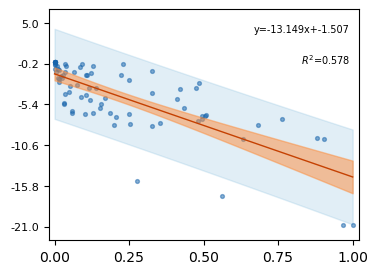

In [8]:
def calculate_error_distdiff_correlation_dQdV(
	dataset_id:str, pulse_type:str, results_to_compare=('fine_tuning', 'source_on_target'), 
	result_metric:str='mape', difference_metric:str='kld', 
	difference_function:ErrorFunction=AbsoluteChange, phases:list=('p1', 'p2', 'p3')):
	"""_summary_

	Args:
		dataset_id (str): _description_
		pulse_type (str): _description_
		results_to_compare (tuple, optional): A 1-tuple or 2-tuple of the following {'source_on_source', 'source_on_target', 'fine_tuning', 'target_only'}. Defaults to ('fine_tuning', 'source_on_target').
		result_metric (str, optional): {'mape', 'rmse', 'mae', 'r2'}. Defaults to 'mape'
		difference_metric (str, optional): {'kld', 'cross_entropy', 'emd', 'isd', 'mmd'}. Defaults to 'kullback_leibler'.
		difference_function (ErrorFunction): An ErrorFunction class to calculate the difference between results. Defaults to AbsoluteChange.
		phases (list): must contain a combination of the following: ['p1', 'p2', 'p3', 'all']
	Returns:
		tuple: linear_model, difference_vals, performance_vals
	"""

	#region: get performance_vals and difference_vals
	# get fine_tuning errors 
	performance_vals = get_finetuning_errors(
		dataset_id=dataset_id,
		pulse_type=pulse_type,
		results_to_compare=results_to_compare,
		error_metric=result_metric,
		error_difference_fnc=difference_function,
		remove_outliers=False
	)['mean'].reshape(-1,1)
	# get distribution difference metrics
	difference_vals = get_dQdV_distribution_differences(
		dataset_id=dataset_id,
		pulse_type=pulse_type,
		difference_metric=difference_metric,
		normalize=False,
		phases=phases,
	).reshape(-1,1)
	#endregion

	#region: normalize difference values
	from sklearn.preprocessing import MinMaxScaler
	scaler = MinMaxScaler().fit(difference_vals)
	difference_vals = scaler.transform(difference_vals)
	#endregion

	# fit linear model
	import statsmodels.api as sm
	linear_model = sm.OLS(performance_vals, sm.add_constant(difference_vals)).fit()

	return linear_model, difference_vals, performance_vals

def plot_error_distdiff_correlation_dQdV(
		dataset_id:str, pulse_type:str, results_to_compare=('fine_tuning', 'source_on_target'), 
		result_metric:str='mape', difference_metric:str='kld', 
		difference_function:ErrorFunction=AbsoluteChange, phases:list=('p1', 'p2', 'p3'),
		**kwargs):
	"""_summary_

	Args:
		dataset_id (str): _description_
		pulse_type (str): _description_
		results_to_compare (tuple, optional): A 1-tuple or 2-tuple of the following {'source_on_source', 'source_on_target', 'fine_tuning', 'target_only'}. Defaults to ('fine_tuning', 'source_on_target').
		result_metric (str, optional): {'mape', 'rmse', 'mae', 'r2'}. Defaults to 'mape'
		difference_metric (str, optional): {'kld', 'cross_entropy', 'emd', 'isd', 'mmd'}. Defaults to 'kullback_leibler'.
		difference_function (ErrorFunction): An ErrorFunction class to calculate the difference between results. Defaults to AbsoluteChange.
		phases (list): must contain a combination of the following: ['p1', 'p2', 'p3', 'all']
		**kwargs: {'fig', 'ax', 'title', 'xlabel', 'ylabel', 'alpha', 'show_ci', 'show_pi', 'show_annotations'}
	"""

	#region: unpack kwargs
	title, xlabel, ylabel = '', '', ''
	if 'title' in kwargs: title = kwargs['title']
	if 'xlabel' in kwargs: xlabel = kwargs['xlabel']
	if 'ylabel' in kwargs: ylabel = kwargs['ylabel']
	alpha = 0.05
	if 'alpha' in kwargs: alpha = kwargs['alpha']
	fig, ax = None, None
	if 'fig' in kwargs and 'ax' in kwargs: 
		fig = kwargs['fig']
		ax = kwargs['ax']
	else:
		fig, ax = plt.subplots(figsize=(4,3))
	show_ci, show_pi = True, True
	if 'show_ci' in kwargs: show_ci = kwargs['show_ci']
	if 'show_pi' in kwargs: show_pi = kwargs['show_pi']
	show_annotations = True
	if 'show_annotations' in kwargs: show_annotations = kwargs['show_annotations']
	#endregion

	#region: calaculate best fit
	linear_model, difference_vals, performance_vals = calculate_error_distdiff_correlation_dQdV(
		dataset_id=dataset_id, pulse_type=pulse_type, results_to_compare=results_to_compare,
		result_metric=result_metric, difference_metric=difference_metric, difference_function=AbsoluteChange, phases=phases)

	# predict best fit line
	x_pred_range = np.linspace(0,1,100).reshape(-1,1)
	y_pred = linear_model.predict(sm.add_constant(x_pred_range))
	
	# get prediction and confidence intervals
	_ = linear_model.conf_int(alpha=alpha, cols=None)
	summary = linear_model.get_prediction(sm.add_constant(x_pred_range)).summary_frame()
	#endregion

	#region: plot
	# plotting layers zorder (back --> front): PI, raw data, CI, best fit
	if show_pi:
		ax.fill_between(
			x_pred_range.flatten(),
			summary['obs_ci_lower'].values,
			summary['obs_ci_upper'].values,
			color=mpl.cm.Blues(0.5), alpha=0.2, 
			label=f'{round((1-alpha)*100)}% PI',
			zorder=5)
	if show_ci:
		ax.fill_between(
			x_pred_range.flatten(),
			summary['mean_ci_lower'].values,
			summary['mean_ci_upper'].values,
			color=mpl.cm.Oranges(0.5), alpha=0.5, 
			label=f'{round((1-alpha)*100)}% CI',
			zorder=9)
	
	ax.scatter(
		difference_vals,
		performance_vals, 
		color=mpl.cm.Blues(0.8), alpha=(0.5 if len(difference_vals) < 100 else 0.2), 
		marker='.', s=2 if len(difference_vals) > 100 else 30, 
		label='Data',
		zorder=7)
	ax.plot(
		x_pred_range, y_pred, '-', linewidth=1,
		color=mpl.cm.Oranges(0.8), alpha=1.0, 
		label='Fit',
		zorder=11)
	
	if not title == '': ax.set_title(title)
	if not xlabel == '': ax.set_xlabel(xlabel, fontsize=8)
	if not ylabel == '': ax.set_ylabel(ylabel, fontsize=8)
	ax.set_xlim(-0.02,1.02)
	ax.set_xticks(np.arange(0,1.001,0.25))
	#endregion

	params_dict = {
		'y_true': performance_vals.reshape(-1), 
		'y_pred': linear_model.predict(sm.add_constant(difference_vals)),
		'x_true': difference_vals.reshape(-1),
		'ci_x': x_pred_range,
		'ci_lower': summary['mean_ci_lower'].values,
		'ci_upper': summary['mean_ci_upper'].values,
		'pi_x': x_pred_range,
		'pi_lower': summary['obs_ci_lower'].values,
		'pi_upper': summary['obs_ci_upper'].values,
		'coefficients':linear_model.params
	}
	
	r2 = r2_score(params_dict['y_true'], params_dict['y_pred'])
	intercept, slope = params_dict['coefficients']
	
	#region: set ft performance tick labels
	ymax = np.max(np.hstack([params_dict['y_true'], params_dict['pi_upper']]))
	ymax = np.sign(ymax) * np.ceil(abs(ymax))
	ymin = np.min(np.hstack([params_dict['y_true'], params_dict['pi_lower']]))
	ymin = np.sign(ymin) * np.ceil(abs(ymin))
	ydelta = round((ymax-ymin)/5, 2)
	perf_ticks = np.arange(ymin, ymax+1e-6, ydelta)
	ax.set_yticks(perf_ticks, np.round(perf_ticks, 2), fontsize=8)
	ax.set_ylim(ymin-(ydelta/3), ymax+(ydelta/3))
	#endregion

	#region: add annotations
	if show_annotations:
		increasing = True
		sort_idxs = np.argsort(params_dict['x_true'].flatten())
		if np.mean(params_dict['y_true'].flatten()[sort_idxs][0:2]) > np.mean(params_dict['y_true'].flatten()[sort_idxs][-2:]): increasing = False
		if increasing:
			ax.annotate(f"y={round(slope,3)}x+{round(intercept,3)}", xy=(0.04,0.90), xycoords='axes fraction', ha='left', fontsize=7)
			ax.annotate(f"$R^2$={round(r2, 3)}", xy=(0.04,0.76), xycoords='axes fraction', ha='left', fontsize=7)
		else:
			ax.annotate(f"y={round(slope,3)}x+{round(intercept,3)}", xy=(0.97,0.90), xycoords='axes fraction', ha='right', fontsize=7)
			ax.annotate(f"$R^2$={round(r2, 3)}", xy=(0.97,0.76), xycoords='axes fraction', ha='right', fontsize=7)
	#endregion

	return fig, ax, params_dict


dataset_id='UConn-ILCC-NMC'
pulse_type='chg'
results_to_compare=('fine_tuning', 'source_on_target')
difference_function=AbsoluteChange

fig, ax, params = plot_error_distdiff_correlation_dQdV(
	dataset_id=dataset_id,
	pulse_type=pulse_type,
	results_to_compare=results_to_compare,
	difference_metric='kld',
	difference_function=difference_function,
	phases=['p1',]
)
plt.show()

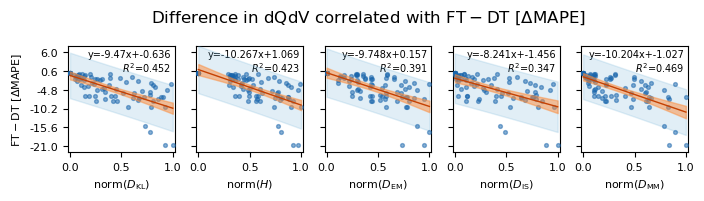

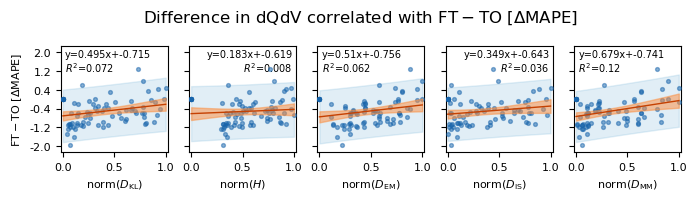

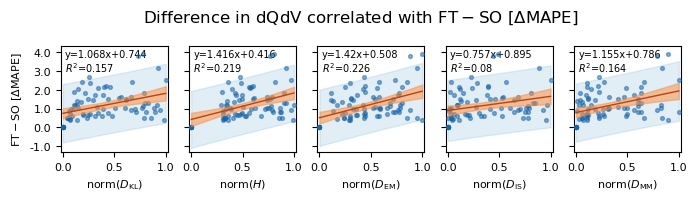

In [10]:
# Plot all correlations 
comparison_map = {
	0:{'results_to_compare':('fine_tuning', 'source_on_target'), 
		'label':r"$\mathrm{FT}-\mathrm{DT}\ [\Delta \mathrm{MAPE}]$",
		'filename':'(FT-DT)'},
	1:{'results_to_compare':('fine_tuning', 'target_only'), 
		'label':r"$\mathrm{FT}-\mathrm{TO}\ [\Delta \mathrm{MAPE}]$",
		'filename':'(FT-TO)'},
	2:{'results_to_compare':('fine_tuning', 'source_on_source'), 
		'label':r"$\mathrm{FT}-\mathrm{SO}\ [\Delta \mathrm{MAPE}]$",
		'filename':'(FT-SO)'},
	# 3:{'results_to_compare':('fine_tuning',), 
	# 	'label':r"$\mathrm{FT}\ [\mathrm{MAPE}]$",
	# 	'filename':'(FT)'},
}
for k,vals in comparison_map.items():
	comparison = vals['results_to_compare']
	comparison_label = vals['label']

	fig, axes = plt.subplots(figsize=(8,1.375), ncols=5, sharey=True)
	for i in range(1,5):
		plt.setp(axes[i].get_yticklabels(), visible=False)
		xlabel_map = {
			'kld':r"$\mathrm{norm}(D_{\mathrm{KL}})$",
			'cross_entropy':r"$\mathrm{norm}(H)$",
			'emd':r"$\mathrm{norm}(D_{\mathrm{EM}})$",
			'isd':r"$\mathrm{norm}(D_{\mathrm{IS}})$",
			'mmd':r"$\mathrm{norm}(D_{\mathrm{MM}})$",
		}
	for i, diff_metric in enumerate(['kld', 'cross_entropy', 'emd', 'isd', 'mmd']):
		fig, axes[i], data = plot_error_distdiff_correlation_dQdV(
			dataset_id=dataset_id,
			pulse_type=pulse_type,
			results_to_compare=comparison,
			result_metric='mape',
			difference_metric=diff_metric, 
			difference_function=difference_function,

			fig=fig,
			ax=axes[i],
			xlabel=xlabel_map[diff_metric],
		)
		axes[i].set_xticks(np.arange(0,1.001,0.5), np.arange(0,1.001,0.5), fontsize=8)
		if i == 0:
			axes[i].set_ylabel(comparison_label, fontsize=8)

	fig.suptitle(f"Difference in dQdV correlated with {comparison_label}", y=1.15)
	plt.show()


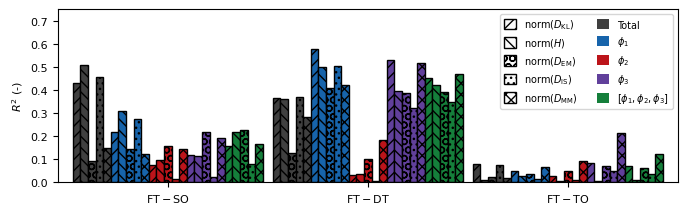

In [11]:
# for a given difference metric
dataset_id=  'UConn-ILCC-NMC'
pulse_type = 'chg'
file_type = 'png'
save = False

#region: plot correlation of all metrics, all phase combinations, and all performance definitons
comparison_map = {
	0:{'results_to_compare':('fine_tuning', 'source_on_source'), 
		'label':r"$\mathrm{FT}-\mathrm{SO}$",
		'filename':'(FT-SO)'},
	1:{'results_to_compare':('fine_tuning', 'source_on_target'), 
		'label':r"$\mathrm{FT}-\mathrm{DT}$",
		'filename':'(FT-DT)'},
	2:{'results_to_compare':('fine_tuning', 'target_only'), 
		'label':r"$\mathrm{FT}-\mathrm{TO}$",
		'filename':'(FT-TO)'},
}
phases_map = {
	0:{'phases':('all',), 
		'label':'Total',
		'cmap':mpl.cm.Grays},
	1:{'phases':('p1',), 
		'label':r'$\phi_{\mathrm{1}}$',
		'cmap':mpl.cm.Blues},
	2:{'phases':('p2',), 
		'label':r'$\phi_{\mathrm{2}}$',
		'cmap':mpl.cm.Reds},
	3:{'phases':('p3',), 
		'label':r'$\phi_{\mathrm{3}}$',
		'cmap':mpl.cm.Purples},
	4:{'phases':('p1','p2','p3'), 
		'label':r'$[\phi_{\mathrm{1}},\phi_{\mathrm{2}},\phi_{\mathrm{3}}]$',
		'cmap':mpl.cm.Greens},
}
difference_metric_map = {
	0:{'metric':'kld', 
		'label':r"$\mathrm{norm}(D_{\mathrm{KL}})$", 
		'hatch':"///", 	},
	1:{'metric':'cross_entropy', 
		'label':r"$\mathrm{norm}(H)$", 
		'hatch':"\\\\\\", 	},
	2:{'metric':'emd', 
		'label':r"$\mathrm{norm}(D_{\mathrm{EM}})$", 
		'hatch':"OO", 	},
	3:{'metric':'isd', 
		'label':r"$\mathrm{norm}(D_{\mathrm{IS}})$", 
		'hatch':"...", 	},
	4:{'metric':'mmd', 
		'label':r"$\mathrm{norm}(D_{\mathrm{MM}})$", 
		'hatch':"xxx", 	},
}

difference_function = AbsoluteChange
bar_ratio = 0.95	# 0.0 to 1.0

n_p = len(phases_map.values())
n_d = len(difference_metric_map.values())
bar_width = bar_ratio / n_p / n_d

fig, ax = plt.subplots(figsize=(8,2.25))
# iterate through FT performance definitions (FT-SO, FT-DT, FT-TO)
for i, c_dict in comparison_map.items():
	# iterate through each combination of phases ('all', 'p1'+'p2'+'p3', etc)
	for j, p_dict in phases_map.items():
		# iteratire through each difference metric
		for k, d_dict in difference_metric_map.items():
			x_loc = i + bar_width*n_d*(j-n_p/2) + bar_width*k
			
			#region: calculate R2
			linear_model, difference_vals, performance_vals = calculate_error_distdiff_correlation_dQdV(
				dataset_id=dataset_id,
				pulse_type=pulse_type,
				results_to_compare=c_dict['results_to_compare'],
				difference_metric=d_dict['metric'],
				difference_function=difference_function,
				phases=p_dict['phases'])
			params_dict = {
				'y_true': performance_vals.reshape(-1), 
				'y_pred': linear_model.predict(sm.add_constant(difference_vals)),
				'x_true': difference_vals.reshape(-1),
				'coefficients':linear_model.params
			}
			r2 = r2_score(params_dict['y_true'], params_dict['y_pred'])
			#endregion

			ax.bar(
				x_loc, r2, width=bar_width, align='edge',
				hatch=d_dict['hatch'], edgecolor='k', linewidth=1,
				color=p_dict['cmap'](0.8))

#region: set labels
handles = [
	mpl.patches.Rectangle(
		xy=(0,0), width=0.5, height=0.5, 
		facecolor='#FAFAFA', hatch=d_dict['hatch'], edgecolor='k', linestyle='-',
		label=d_dict['label']
	)
	for d_dict in difference_metric_map.values()]
handles.extend([
	mpl.patches.Rectangle(
		xy=(0,0), width=0.5, height=0.5, 
		facecolor=p_dict['cmap'](0.8), label=p_dict['label']
	)
	for p_dict in phases_map.values()])
ax.legend(
	handles=handles, handlelength=1.25, handleheight=1.25,
	loc='upper right', ncols=2, fontsize=7)

ax.set_xticks(np.arange(len(comparison_map.keys())), [x['label'] for x in comparison_map.values()], fontsize=8)
ax.set_xlim(-0.55, 2.55)
ax.set_ylabel("$R^2$ (-)", fontsize=8)
ax.set_ylim(0, 0.75)
ax.set_yticks(np.arange(0,0.75,0.1), np.arange(0,0.75,0.1).round(1), fontsize=8)
#endregion
#endregion

dir_save = dir_figures.joinpath("dQdV Analysis", "Distribution Difference",)
dir_save.mkdir(exist_ok=True, parents=True)
filename = f"dQdV_Correlation {dataset_id} {pulse_type}.{file_type}"
if save: fig.savefig(dir_save.joinpath(filename), dpi=300, bbox_inches='tight')
plt.show()

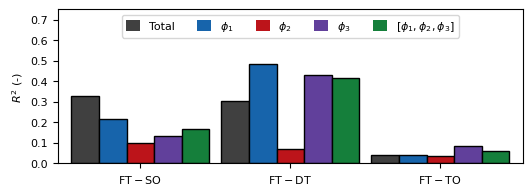

In [12]:
#region: plot AVERAGE correlation across all metrics, for all phase combinations and all performance definitons
comparison_map = {
	0:{'results_to_compare':('fine_tuning', 'source_on_source'), 
		'label':r"$\mathrm{FT}-\mathrm{SO}$",
		'filename':'(FT-SO)'},
	1:{'results_to_compare':('fine_tuning', 'source_on_target'), 
		'label':r"$\mathrm{FT}-\mathrm{DT}$",
		'filename':'(FT-DT)'},
	2:{'results_to_compare':('fine_tuning', 'target_only'), 
		'label':r"$\mathrm{FT}-\mathrm{TO}$",
		'filename':'(FT-TO)'},
}
phases_map = {
	0:{'phases':('all',), 
		'label':'Total',
		'cmap':mpl.cm.Grays},
	1:{'phases':('p1',), 
		'label':r'$\phi_{\mathrm{1}}$',
		'cmap':mpl.cm.Blues},
	2:{'phases':('p2',), 
		'label':r'$\phi_{\mathrm{2}}$',
		'cmap':mpl.cm.Reds},
	3:{'phases':('p3',), 
		'label':r'$\phi_{\mathrm{3}}$',
		'cmap':mpl.cm.Purples},
	4:{'phases':('p1','p2','p3'), 
		'label':r'$[\phi_{\mathrm{1}},\phi_{\mathrm{2}},\phi_{\mathrm{3}}]$',
		'cmap':mpl.cm.Greens},
}
difference_metric_map = {
	0:{'metric':'kld', 
		'label':r"$\mathrm{norm}(D_{\mathrm{KL}})$", 
		'hatch':"///", 	},
	1:{'metric':'cross_entropy', 
		'label':r"$\mathrm{norm}(H)$", 
		'hatch':"\\\\\\", 	},
	2:{'metric':'emd', 
		'label':r"$\mathrm{norm}(D_{\mathrm{EM}})$", 
		'hatch':"OO", 	},
	3:{'metric':'isd', 
		'label':r"$\mathrm{norm}(D_{\mathrm{IS}})$", 
		'hatch':"...", 	},
	4:{'metric':'mmd', 
		'label':r"$\mathrm{norm}(D_{\mathrm{MM}})$", 
		'hatch':"xxx", 	},
}

difference_function = AbsoluteChange
bar_ratio = 0.92	# 0.0 to 1.0

n_p = len(phases_map.values())
n_d = len(difference_metric_map.values())
bar_width = bar_ratio / n_p / n_d

fig, ax = plt.subplots(figsize=(6,2))
# iterate through FT performance definitions (FT-SO, FT-DT, FT-TO)
for i, c_dict in comparison_map.items():
	# iterate through each combination of phases ('all', 'p1'+'p2'+'p3', etc)
	for j, p_dict in phases_map.items():
		x_loc = i + bar_width*n_d*(j-n_p/2)

		r2 = 0
		# iterate through each difference metric
		for k, d_dict in difference_metric_map.items():
			#region: calculate R2
			linear_model, difference_vals, performance_vals = calculate_error_distdiff_correlation_dQdV(
				dataset_id=dataset_id,
				pulse_type=pulse_type,
				results_to_compare=c_dict['results_to_compare'],
				difference_metric=d_dict['metric'],
				difference_function=difference_function,
				phases=p_dict['phases'])
			params_dict = {
				'y_true': performance_vals.reshape(-1), 
				'y_pred': linear_model.predict(sm.add_constant(difference_vals)),
				'x_true': difference_vals.reshape(-1),
				'coefficients':linear_model.params
			}
			r2 += r2_score(params_dict['y_true'], params_dict['y_pred'])
			#endregion
		r2 /= n_p

		ax.bar(
			x_loc, r2, width=bar_width*n_d, align='edge',
			hatch=None, edgecolor='k', linewidth=1,
			color=p_dict['cmap'](0.8))

#region: set labels
handles = [
	mpl.patches.Rectangle(
		xy=(0,0), width=0.5, height=0.5, 
		facecolor=p_dict['cmap'](0.8), label=p_dict['label']
	)
	for p_dict in phases_map.values()]

ax.legend(
	handles=handles, handlelength=1.25, handleheight=1.25,
	loc='upper center', ncols=5, fontsize=8)

ax.set_xticks(np.arange(len(comparison_map.keys())), [x['label'] for x in comparison_map.values()], fontsize=8)
ax.set_xlim(-0.55, 2.55)
ax.set_ylabel("$R^2$ (-)", fontsize=8)
ax.set_ylim(0, 0.75)
ax.set_yticks(np.arange(0,0.75,0.1), np.arange(0,0.75,0.1).round(1), fontsize=8)
#endregion
#endregion

dir_save = dir_figures.joinpath("dQdV Analysis", "Distribution Difference",)
dir_save.mkdir(exist_ok=True, parents=True)
filename = f"dQdV_AvgCorrelation {dataset_id} {pulse_type}.{file_type}"
if save: fig.savefig(dir_save.joinpath(filename), dpi=300, bbox_inches='tight')
plt.show()